# *Предсказание рейтинга качества шоколада по его характеристикам*

[пользователь Kaggle]

## Резюме/Выводы

Работа над данным соревнованием заняла много экранных разворотов кода и экспериментов в двух ноутбуках. Чтобы структурировать хаотичность своих разрозненных экспериментов и размышлений, изложу в самом начале самые важные выводы и подходы, которые привели к результу метрики r2 на тестовых данных в 0.21859. Все эксперименты и код, показывающие эти выводы и подходы представлены в этом ноубуке после описания базовых разделов по описанию реализации основных решений.

Мне не удалось преодолеть требуемый порог за последние сутки, не уверен, что смогу в дальнейшем. Если удастся завершить до проверки, просто допишу здесь доп.информацию, основные выводы и структура вряд ли изменятся.

**Выводы:**

С самого начала верной стратегией казалось присвоить пропущенным, пустым и редковстречающимся значениям категорию "Other", удалить сильно коррелированные столбцы, закодировать категориальные столбцы подходящим энкодером, найти лучшую модель на кросс-валидации, и тонко настроить её параметры через Optuna. Это не сработало совсем:

*   Датасет оказался крайне ригидным в работе с пропущенными значениями, работе по группировке, и укрупнению данных. Более того, такие манипуляции чаще не только не улучшают качество работы моделей, но зачастую ухудшают его;
*   Несмотря на то, что как минимум две группы столбцов сильно связаны между собой (Review и REF, Bean Type, Broad Bean Origin и Company Location) согласно таблиц корреляции Крамера и Фика, удаление, как мне казалось, определённо избыточных столбцов Review и Broad Bean Origin резко ухудшает предсказательную способность моделей;
* Любые манипуляции с датасетом не приводят к смене лучшей модели: CatBoost всегда значительно оперживает в качестве иные модели, которые могут ротироваться в рейтинге в зависимости от характера предварительной обработки данных;
* Кодирование любым способом категориальных столбцов сильно уступает встроенному алгоритму в CatBoost, более того только вроде бы более приметивный OneHotEncoder позволяет  CatBoost не слишком сильно просесть в качестве;
* Масштабирование данных любым из скейлеров не приводит к значимому изменению результатов нелинейных моделей, линейные модели слишком плохи для решения этой задачи.


Удалось нащупать **две работающие стратегии**:

1. Стратегия, давшая лучший скор:
* Пропущенным значениям присваиваем категорию Unknown;
* Исправляем колонки, с неправильным написанием и прочие мелочи (Domincan Republic);
* Предсказываем истиные категории для Unknown по остальным закодированным категориальным столбцам с помощью модели CatBoostClassifier;
* Преобразовываем столбец Cocoa Percent в числовой float формат;
* Удаляем из датасета те колонки, в которых  Cocoa Percent> 99% (признаём их выбросами согласно гистограммы распределения значений);
* Выбираем на кросс-валидации лучшую модель (CatBoostRegressor), подбираем оптимальные параметры для CatBoost с помощью Optuna (автокодирование категриальных колонок самой моделью, n_estimators=116, max_depth=3).

2. Гораздо более простой и универсальный подход, дающий <2% в качестве по сравнению с прошлым вариантом:
* Пропущенным значениям присваиваем категорию Unknown (без последующей обработки);
* Обучаем на кросс-валидации на нашем наборе от пяти моделей CatBoost с помощью cross_validate из sklearn.model_selection (работает как cross_val_score, но позволяет сохранять обученные модели);
* Применяем к тестовым данным усредненные предсказания всех моделей (или лучшую модель, но так как правило хуже)

Кажется это вполне стекинг. Данный подход неплохо работает и с другими моделями бустинга и решающими деревьями, однако в этом случае приходится кодировать категориальные столбцы OHE (с ручным удалением одного из закодированных столбцов), а качество на выходе получается похуже.

**Эффективные инструменты:**

В ходе решения задачи удалось найти несколько инструментов за пределами учебной программы, упрощающим жизнь:
* Функция cross_validate из sklearn.model_selection (см. выше)
* Библиотека pandas_profiling, которая позволяет получить довольно полный и качественный анализ датасета (анализ корреляции и изыточности/недостаточности информации в них, анализ на наличие дублей, корреляция столбцов с помощью построения матриц корреляции Спирмана, Пирсона, Кенделла, Крамера и Фика (!);
* Матрицу корреляции Фика выделю отдельно: Phik - это новый и практичный коэффициент корреляции, который последовательно работает между категориальными, порядковыми и интервальными переменными, учитывает нелинейную зависимость и возвращается к коэффициенту корреляции Пирсона в случае двумерного нормального распределения входных данных: https://phik.readthedocs.io/en/latest/index.html.








# Лучшая стратегия


## Импорт библиотек, константы, загрузка данных








Здесь описаны финальные и эффективные преобразования. В самом конце будет оставлю все остальные последовательные фрагментарные размышления, с которыми можно ознакомиться, если интересно.

In [ ]:
!pip install category_encoders -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 KB 2.8 MB/s eta 0:00:00


In [ ]:
!pip install catboost -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 12.0 MB/s eta 0:00:00


In [ ]:
!pip install xgboost -q

In [ ]:
!pip install lightgbm -q

In [ ]:
!pip install optuna -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 KB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.3/212.3 KB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 9.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import pandas_profiling as pp
# ignore potential warnings
import warnings
warnings.filterwarnings('ignore')


from category_encoders.leave_one_out import LeaveOneOutEncoder
from category_encoders.one_hot import OneHotEncoder
from category_encoders.target_encoder import TargetEncoder

from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, Pool


import optuna

In [ ]:
TRAIN = "https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/chocolate_train.csv"
TEST = "https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/chocolate_test_new.csv"

In [ ]:
train_df = pd.read_csv(TRAIN)
test_df = pd.read_csv(TEST)

## Обзор данных, промежуточный вывод

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1255 entries, 0 to 1254
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Company            1255 non-null   object 
 1   Review             1255 non-null   int64  
 2   Cocoa Percent      1255 non-null   float64
 3   Company Location   1255 non-null   object 
 4   Rating             1255 non-null   float64
 5   Bean Type          1255 non-null   object 
 6   Broad Bean Origin  1255 non-null   object 
dtypes: float64(2), int64(1), object(4)
memory usage: 68.8+ KB


Я много проводил ручного анализа (фрагменты кода и размышлений в самых последних необязательных разделах), но после того, как попробовал библиотеку pandas_profiling, это перестало иметь смысл:

In [ ]:
#  profile report of the all train dataset
pp.ProfileReport(train_df, title = 'Profiling Report of the Chocolate Ratings Dataset',
                html = {'style':{'full_width':True}})

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

На вкладе alert видно, что четыре столбца признаны избыточно детализироваными. Я пытался укрупнять эти категории (в следующем разделе есть соответствующий код), однако ввиду того, что преобразования приводили лишь к ухудшению в работе моделей, отказался от большинства манипуляций.

Также в разделе Alert и из матриц корреляций хорошо видно, что много категориальных столбцов имеют сильную взаимосвязаны друг с другом.

<Axes: >

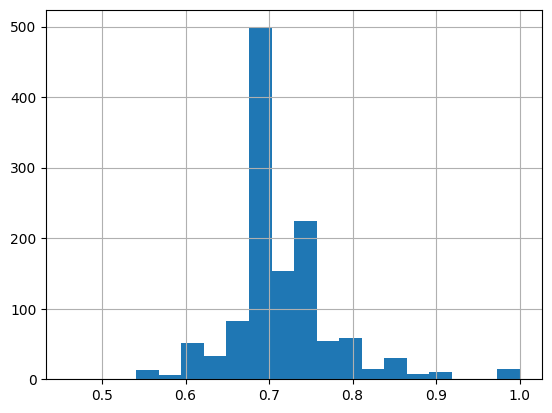

In [ ]:
train_df['Cocoa Percent'].hist(bins=20)

Отдельного внимания заслуживает распределение целевой переменной. В целом она мне на первый взгляд казалась вполне нормально распределенной и не требующей никаких к себе преобразований. Однако сейчас мне кажется, что нужно избавляться от крайних значений самых хороших и самых плохих рейтингов, так как они напоминают выбросы. Я сам отсек значения качества кокао > 99% (см. верхний график), и это дало сильное улучшение качества модели. Теперь мне кажется, что, скорее всего эти значения коррелируют с низкими рейтингами, т.е. я на самом деле отсек часть выбросов целевой переменной. Возможно нужно проверить свою теорию и полностью отсечь её выбросы (скажем, убрать значения ниже 2 и более 4.5).

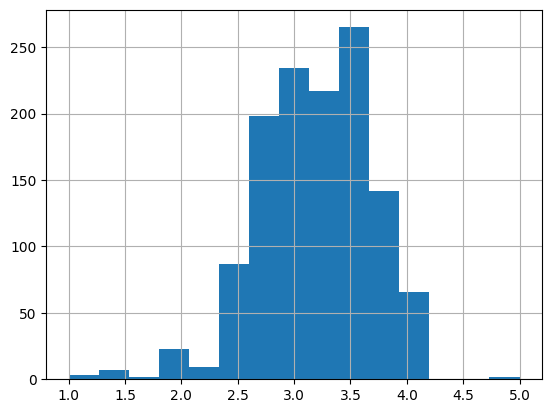

In [ ]:
train_df['Rating'].hist(bins=15);

## Обработка пропусков и выбросов

In [ ]:
def short_transform_df(df):
  """Осуществляет предварительную обработку данных"""
  df = df.replace(np.nan, 'Unknown') # обработка nan-строк
  df = df.replace(r'^\s*$', 'Unknown', regex=True) # обработка строк, которые имеют специальные символы
  df['Cocoa Percent'] = df['Cocoa Percent'].apply(lambda x: float(x.strip('%')) / 100.0) # приводим столбец с процентами к числовому формату
  df['Bean Type'] = df['Bean Type'].apply(lambda x: x.split()[0].strip().strip(',')) # отсекаем первое слово в столце, с тем, чтобы унифицировать разное написание сортов
  df['Broad Bean Origin'] = df['Broad Bean Origin'].apply(lambda x: "Dominican Republic" if x == 'Domincan Republic' else x) # исправляем самую критичную опечатку в данных, которая затрагивает много столбцов
  df.drop_duplicates(inplace=True) # удалуем дубликаты
  df.drop(columns=['Review'], inplace=True) # удаляем единственный сильно кореллирующий признак
  # Обработка ниже признано неэффективной для данного датасета
  # rear_beans = df['Bean Type'].value_counts()[5:].index.tolist()
  # most_bean_origin = df['Broad Bean Origin'].value_counts()[df['Broad Bean Origin'].value_counts() > 10].index.tolist()
  # most_located_countries = df['Company Location'].value_counts()[df['Company Location'].value_counts() > 10].index.tolist()
  # most_specific_countries = df['Specific Bean Origin'].value_counts()[df['Specific Bean Origin'].value_counts() > 10].index.tolist()
  # df['Bean Type'] = df['Bean Type'].apply(lambda x: x if x not in rear_beans else 'Other')
  # df['Broad Bean Origin'] = df['Broad Bean Origin'].apply(lambda x: x if x in most_bean_origin else 'Other')
  # df['Company Location'] = df['Company Location'].apply(lambda x: x if x in most_located_countries else 'Other')
  # df['Specific Bean Origin'] = df['Specific Bean Origin'].apply(lambda x: x if x in most_specific_countries else 'Other')

  # df.drop(columns=['Specific Bean Origin', 'REF'], inplace=True)
  # df.drop(columns=['Specific Bean Origin', 'REF', 'Company Location', 'Review'], inplace=True)
  return df

Как видите из закомментированного кода, была попытка укрупнения/объединения данных по многим признакам в разных аспектах, но подготовленные на них модели показатели несостоятельность этого подхода. Я пришёл к выводу, что, например, CatBoost примерно тоже самое умеет делать под капотом, но гораздо эффективнее и умнее, чем моя реализация

In [ ]:
def prepare_train(train_df):
  # train_df = pd.read_csv('chocolate_train.csv')
  train_df = short_transform_df(train_df)
  X_train = train_df.drop('Rating', axis=1)
  y_train = train_df['Rating']
  cat_cols = X_train.select_dtypes(include=['object']).columns
  cat_features = [list(X_train.columns).index(c) for c in cat_cols]
  return train_df, X_train, y_train, cat_cols, cat_features

In [ ]:
train_df, X_train, y_train, cat_cols, cat_features = prepare_train(train_df)

In [ ]:
X_test = short_transform_df(test_df)

#### Убираем выбросы Cocao Percent из датасета

In [ ]:
X_train = X_train[X_train['Cocoa Percent'] < 1.0]
X_train['rating'] = y_train
y_train = X_train['rating'][X_train['Cocoa Percent'] < 1.0]
X_train.drop(columns='rating', inplace=True)

## Построение новых признаков и отбор признаков, обоснование

Как было описано в резюме, предсказываем значения Unknown в Bean Type на основе данных других категориальных столбцов с помощью CatBoostClassifier

Для этого создаём новые трейн и тест датасеты. Трейн будет содержать только известные значения в столбце Bean Type, в тест попадут все прочие значения

In [ ]:
Data_train = X_train[X_train['Bean Type'] != 'Unknown']
Data_test = X_train[X_train['Bean Type'] == 'Unknown']
Data_train.drop(columns=['REF', 'Cocoa Percent'], inplace=True)
Data_test.drop(columns=['REF', 'Cocoa Percent'], inplace=True)
X_Data_train = Data_train.drop(columns=['Bean Type'])
y_Data_train = Data_train['Bean Type']

In [ ]:
X_Data_train.head(5)

,Company,Specific Bean Origin,Company Location,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,U.K.,Venezuela
3,Brasstown aka It's Chocolate,Cooproagro,U.S.A.,Dominican Republic
4,Pralus,"Java, Indonesie",France,Indonesia
5,Pitch Dark,Chuno,U.S.A.,Nicaragua
7,Shark Mountain,Cuyagua,U.S.A.,Venezuela


In [ ]:
from catboost import CatBoostClassifier
class_model = CatBoostClassifier(cat_features=[0,1,2,3], verbose=0).fit(X_Data_train, y_Data_train)

In [ ]:
Data_test = Data_test.drop(columns=['Bean Type'])

In [ ]:
# получаем предсказания на тесте
labels = class_model.predict(Data_test)

Дальше пристыковываем полученный прогноз и сводим датасеты вместе, уже с учетом уточненных значений на месте Unknown в Bean Type

In [ ]:
X_train['Bean Type'][X_train['Bean Type'] == 'Unknown'] = labels

In [ ]:
X_test[X_test['Bean Type'] == 'Unknown'].drop(columns=['REF', 'Cocoa Percent'])

,Company,Specific Bean Origin,Company Location,Bean Type,Broad Bean Origin
1,Blanxart,Organic Dark,Spain,Unknown,Unknown
7,Acalli,"Chulucanas, El Platanal",U.S.A.,Unknown,Peru
10,Holy Cacao,Maranon,Israel,Unknown,Peru
13,DAR,"DUO, batch 002",U.S.A.,Unknown,"Ecuador, Costa Rica"
14,Coppeneur,Ecuador Puristique,Germany,Unknown,Ecuador
...,...,...,...,...,...
535,Monsieur Truffe,Papaua New Guinea,Australia,Unknown,Papua New Guinea
536,Cacao Hunters,Macondo,Colombia,Unknown,Colombia
537,Bonnat,Maragnam,France,Unknown,Brazil
538,Altus aka Cao Artisan,Acopagro,U.S.A.,Unknown,Peru


In [ ]:
X_test['Bean Type'][X_test['Bean Type'] == 'Unknown'] = class_model.predict(X_test[X_test['Bean Type'] == 'Unknown'].drop(columns=['REF', 'Cocoa Percent', 'Bean Type']))

In [ ]:
X_test

,Company,Specific Bean Origin,REF,Cocoa Percent,Company Location,Bean Type,Broad Bean Origin
0,Ohiyo,"San Juan Estate, Gran Couva",1594,0.70,U.S.A.,Trinitario,Trinidad
1,Blanxart,Organic Dark,322,0.72,Spain,Criollo,Unknown
2,Brazen,Maya Mountain,1518,0.80,U.S.A.,Trinitario,Belize
3,Patric,Madagascar,439,0.67,U.S.A.,Trinitario,Madagascar
4,Potomac,"Upala, Batch 12",607,0.82,U.S.A.,Matina,Costa Rica
...,...,...,...,...,...,...,...
535,Monsieur Truffe,Papaua New Guinea,1391,0.70,Australia,Trinitario,Papua New Guinea
536,Cacao Hunters,Macondo,1816,0.71,Colombia,Criollo,Colombia
537,Bonnat,Maragnam,1038,0.75,France,Criollo,Brazil
538,Altus aka Cao Artisan,Acopagro,1728,0.60,U.S.A.,Forastero,Peru


## Построение модели

Предварительно на кросс-валидации CatBoost показал себя существенно лучше, поэтому здесь описана только его настройка. Эксперименты с другими моделями можно найти в последних разделах данного ноутбука

Начнём с параметрами по умолчанию и кодированием средствами самого CatBoost

In [ ]:
model0 = CatBoostRegressor(verbose=0, cat_features=[0,1,4,5,6])

In [ ]:
model0.fit(X_train, y_train_new)

In [ ]:
pred0 = model0.predict(X_test)

In [ ]:
r2_score(y_test, pred0)

0.19023057260191722

На валидационных данных получаются неплохие результаты. Давайте подбирать параметры с помощью Optuna и сохранять полученные результаты для валидации на Каггл.

In [ ]:
def objective(trial):

    param = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 1000),
        "max_depth": trial.suggest_int("max_depth", 2, 16),
    }

    estimator = CatBoostRegressor(**param, verbose=False, cat_features=[0,1,4,5,6])

    estimator.fit(X_train, y_train_new)
    pred = estimator.predict(X_test)

    return r2_score(y_test, pred)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=25)
print(study.best_trial)

[I 2023-04-07 20:50:27,640] A new study created in memory with name: no-name-4ece190f-366a-4652-8808-750a8117dcc9
[I 2023-04-07 20:50:34,864] Trial 0 finished with value: 0.16073733872876672 and parameters: {'n_estimators': 850, 'max_depth': 8}. Best is trial 0 with value: 0.16073733872876672.
[I 2023-04-07 20:51:00,832] Trial 1 finished with value: 0.14238795239722968 and parameters: {'n_estimators': 585, 'max_depth': 11}. Best is trial 0 with value: 0.16073733872876672.
[I 2023-04-07 20:51:05,901] Trial 2 finished with value: 0.16009298105761705 and parameters: {'n_estimators': 518, 'max_depth': 8}. Best is trial 0 with value: 0.16073733872876672.
[I 2023-04-07 20:51:06,490] Trial 3 finished with value: 0.15645271624483337 and parameters: {'n_estimators': 139, 'max_depth': 6}. Best is trial 0 with value: 0.16073733872876672.
[I 2023-04-07 20:51:08,428] Trial 4 finished with value: 0.19687579050412862 and parameters: {'n_estimators': 923, 'max_depth': 3}. Best is trial 4 with value: 0

FrozenTrial(number=9, state=TrialState.COMPLETE, values=[0.20605300532435822], datetime_start=datetime.datetime(2023, 4, 7, 20, 55, 10, 764981), datetime_complete=datetime.datetime(2023, 4, 7, 20, 55, 11, 269300), params={'n_estimators': 261, 'max_depth': 4}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=10, step=1), 'max_depth': IntDistribution(high=16, log=False, low=2, step=1)}, trial_id=9, value=None)


Прирост качества наблюдается, пробуем дообучиться ещё

In [ ]:
study.optimize(objective, n_trials=100)
print(study.best_trial)

[I 2023-04-07 21:44:40,071] Trial 75 finished with value: 0.19240479564706214 and parameters: {'n_estimators': 127, 'max_depth': 3}. Best is trial 51 with value: 0.21859527744430463.
[I 2023-04-07 21:44:40,256] Trial 76 finished with value: 0.16557932515109364 and parameters: {'n_estimators': 87, 'max_depth': 5}. Best is trial 51 with value: 0.21859527744430463.
[I 2023-04-07 21:44:40,716] Trial 77 finished with value: 0.19081556467933358 and parameters: {'n_estimators': 331, 'max_depth': 3}. Best is trial 51 with value: 0.21859527744430463.
[I 2023-04-07 21:44:40,802] Trial 78 finished with value: 0.19555404576962865 and parameters: {'n_estimators': 39, 'max_depth': 2}. Best is trial 51 with value: 0.21859527744430463.
[I 2023-04-07 21:44:41,002] Trial 79 finished with value: 0.1989782708847586 and parameters: {'n_estimators': 136, 'max_depth': 4}. Best is trial 51 with value: 0.21859527744430463.
[I 2023-04-07 21:44:41,482] Trial 80 finished with value: 0.18497598175295382 and parame

FrozenTrial(number=51, state=TrialState.COMPLETE, values=[0.21859527744430463], datetime_start=datetime.datetime(2023, 4, 7, 21, 39, 31, 421578), datetime_complete=datetime.datetime(2023, 4, 7, 21, 39, 31, 569677), params={'n_estimators': 116, 'max_depth': 3}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=10, step=1), 'max_depth': IntDistribution(high=16, log=False, low=2, step=1)}, trial_id=51, value=None)


Обучим финальную модель с найденными оптимальными параметрами:

In [ ]:
final_model = CatBoostRegressor(verbose=0, cat_features=[0,1,4,5,6], n_estimators=116, max_depth=3)

In [ ]:
final_model.fit(X_train, y_train_new)

In [ ]:
final_pred = final_model.predict(X_test)

In [ ]:
X_test['id'] = np.arange(len(X_test))
X_test['Rating'] = final_pred

X_test[['id','Rating']].to_csv("final_preds.csv", index=False)

Итак, данный подход позволил добиться моего максимального результата в соревновании

# Универсальная (оптимальная) стратегия

Как было описано раннее, для этого подхода используем продвинутый аналог cross_val_score - функцию cross_validate, которая позволяет сохранять модели на каждом этапе кросс-валидации в случае указания параметра return_estimator=True. Модели сохраняются внутри словаря по ключу 'estimator'

In [ ]:
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, cross_validate
from sklearn.metrics import r2_score

In [ ]:
model0 = CatBoostRegressor(verbose=0, cat_features=[0,1,4,5,6])

In [ ]:
# По сути обучили 5 моделей
scores = cross_validate(model0, X_train, y_train, cv=5, scoring='r2', return_estimator=True)

In [ ]:
# Вот они
scores['estimator']

In [ ]:
# Так можно достать конкретную модель и использовать её для предсказания
pred0 = scores['estimator'][3].predict(X_test)

In [ ]:
r2_score(y_test, pred0)

0.1524166357026061

In [ ]:
# А вот так можно  использовать предсказания всех моделей, усредняя их скор. Это приводит к лучшим результатам
total_score = 0
for model in scores['estimator']:
  total_score += model.predict(X_test)
mean_score = total_score/5

In [ ]:
r2_score(y_test, mean_score)

0.2080658584623305

Этот же подход хорошо тиражируется на проверку качества любых моделей:

In [ ]:
# Кодируем признаки для работы с моделями, которые не умеют напрямую работать с категориальными переменными, удаляем один лишний столбец вручную ввиду отсутствия параметра drop

make_norm = Pipeline([
    ('encoder_',OneHotEncoder(cols=cat_cols))
    ])

X_train_good = make_norm.fit_transform(X_train, y_train)
X_test_good = make_norm.transform(X_test)
X_train_good.drop(columns=['Company_1', 'Specific Bean Origin_1', 'Company Location_1', 'Bean Type_1', 'Broad Bean Origin_1'], inplace=True)
X_test_good.drop(columns=['Company_1', 'Specific Bean Origin_1', 'Company Location_1', 'Bean Type_1', 'Broad Bean Origin_1'], inplace=True)

In [ ]:
models = [LGBMRegressor(), XGBRegressor(), RandomForestRegressor(n_estimators=200, min_samples_leaf=3, n_jobs=-1), GradientBoostingRegressor()]

In [ ]:
def predict_them_all(model):
  total_score = 0
  current_model_score = []
  scores = cross_validate(model, X_train_good, y_train_good, cv=10, scoring='r2', return_estimator=True)
  for model in scores['estimator']:
    current_pred = model.predict(X_test_good)
    current_model_score.append(r2_score(y_test, current_pred))
    total_score += current_pred
  mean_score = total_score/5
  return current_model_score, r2_score(y_test, mean_score)

In [ ]:
for i, model in enumerate(models):
  print(i+1, model)
  models_scores, total_score = predict_them_all(model)
  print(f'Скоры на каждом фолде - {models_scores}')
  print(f'Общий скор: {total_score}')

1 LGBMRegressor()
Скоры на каждом фолде - [0.06370315392116999, 0.06237237056359646, 0.08392250597129758, 0.07406617700152329, 0.049160817812166524, 0.08097248355901698, 0.05479746456949519, 0.0520595881276229, 0.07981169100705754, 0.07027202879092187]
Общий скор - -44.94882273194845
2 XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=No

In [ ]:
models_scores, total_score = predict_them_all(models[2])

In [ ]:
models_scores

[0.10564136982810335,
 0.10983172510668504,
 0.12681450213863832,
 0.1073906957855878,
 0.11062472756348374,
 0.11711414258462594,
 0.09818964339288383,
 0.11427526264567345,
 0.1330131523622724,
 0.10472527161138478]

In [ ]:
scores = cross_validate(models[2], X_train_good, y_train_good, cv=10, scoring='r2', return_estimator=True)

In [ ]:
scores

{'fit_time': array([7.85964084, 5.88920736, 7.91892099, 5.75413299, 7.57458329,
        5.60183525, 6.71865439, 6.1406064 , 6.02810359, 7.18469381]),
 'score_time': array([0.06289935, 0.0567317 , 0.05552864, 0.06077337, 0.06246614,
        0.0623126 , 0.06329417, 0.06418729, 0.06022406, 0.05159211]),
 'estimator': [RandomForestRegressor(min_samples_leaf=3, n_estimators=200, n_jobs=-1),
  RandomForestRegressor(min_samples_leaf=3, n_estimators=200, n_jobs=-1),
  RandomForestRegressor(min_samples_leaf=3, n_estimators=200, n_jobs=-1),
  RandomForestRegressor(min_samples_leaf=3, n_estimators=200, n_jobs=-1),
  RandomForestRegressor(min_samples_leaf=3, n_estimators=200, n_jobs=-1),
  RandomForestRegressor(min_samples_leaf=3, n_estimators=200, n_jobs=-1),
  RandomForestRegressor(min_samples_leaf=3, n_estimators=200, n_jobs=-1),
  RandomForestRegressor(min_samples_leaf=3, n_estimators=200, n_jobs=-1),
  RandomForestRegressor(min_samples_leaf=3, n_estimators=200, n_jobs=-1),
  RandomForestRegre

In [ ]:
for el in range(5):
    print(r2_score(y_test, scores['estimator'][el].predict(X_test_good)))

0.10400787665660627
0.1121214160408045
0.13364185259733863
0.10781600717146334
0.12174075618409919


## Прочие эксперименты (несистематизированный разрозненный код)

In [ ]:
import pandas as pd
import numpy as np

train_df = pd.read_csv('chocolate_train.csv')

In [ ]:
train_df.head()

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,457,2009,72%,U.K.,3.25,Trinitario,Venezuela
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72%,Switzerland,3.50,,Venezuela
2,Dark Forest,Tanzania,1554,2015,70%,U.S.A.,3.00,,Tanzania
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72%,U.S.A.,3.00,Trinitario,Dominican Republic
4,Pralus,"Java, Indonesie",32,2006,75%,France,3.50,Criollo,Indonesia


## Работа с пропущенными значениями

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1255 entries, 0 to 1254
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Company               1255 non-null   object 
 1   Specific Bean Origin  1255 non-null   object 
 2   REF                   1255 non-null   int64  
 3   Review                1255 non-null   int64  
 4   Cocoa Percent         1255 non-null   object 
 5   Company Location      1255 non-null   object 
 6   Rating                1255 non-null   float64
 7   Bean Type             1254 non-null   object 
 8   Broad Bean Origin     1254 non-null   object 
dtypes: float64(1), int64(2), object(6)
memory usage: 88.4+ KB


Проблемы на первый взгляд: есть пропуски в столбцах Bean Type и Broad Bean Origin, столбец Cocoa Percent, числовой по сути, сейчас воспримается как категориальный

In [ ]:
train_df[train_df.isnull().any(axis=1)]

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
697,Mast Brothers,Madagascar,999,2012,72%,U.S.A.,2.5,Trinitario,NaN
1058,Soma,"Three Amigos(Chuao, Wild Bolivia, D.R.)",676,2011,70%,Canada,4.0,NaN,"Ven, Bolivia, D.R."


Если посмотреть внимательнее, то и info(), и baseline-решение показывают, что нулевые значения содержат только две строки. Но из head() видно, что даже в первых пяти строках в столбце "Broad Bean" отсутствуют три значения. Разберемся в причинах расхождений

In [ ]:
train_df['Bean Type'].loc[1]

'\xa0'

Кажется в этом датасете неизвестные данные закодированы неразрывным пробелом. Проверим:

In [ ]:
for c in train_df.columns:
    print(c, len(train_df[train_df[c] == '\xa0']))

Company 0
Specific Bean Origin 0
REF 0
Review 0
Cocoa Percent 0
Company Location 0
Rating 0
Bean Type 628
Broad Bean Origin 55


Как минимум с двумя категориальными колонками это так. Нужно будет подумать, как обработать и пустые строки, и строки с неразрывным пробелом.

In [ ]:
train_df['Bean Type'].value_counts()

                            628
Trinitario                  285
Criollo                     104
Forastero                    53
Forastero (Nacional)         34
Criollo, Trinitario          32
Forastero (Arriba)           32
Blend                        28
Criollo (Porcelana)           9
Forastero (Parazinho)         8
Forastero (Arriba) ASS        6
Trinitario, Criollo           3
Nacional (Arriba)             3
Forastero (Catongo)           2
Criollo, Forastero            2
Criollo (Amarru)              2
Trinitario, Forastero         2
Trinitario (Amelonado)        1
Amazon mix                    1
Trinitario, Nacional          1
Forastero (Amelonado)         1
Criollo (Ocumare 67)          1
Blend-Forastero,Criollo       1
Forastero, Trinitario         1
Criollo (Ocumare 61)          1
Trinitario (85% Criollo)      1
EET                           1
Amazon                        1
Criollo (Wild)                1
Matina                        1
Criollo, +                    1
Criollo 

In [ ]:
train_df['Broad Bean Origin'].value_counts()

Venezuela                  144
Ecuador                    142
Peru                       122
Dominican Republic         104
Madagascar                 103
                          ... 
Ven., Indonesia, Ecuad.      1
Ven., Trinidad, Mad.         1
Peru, Dom. Rep               1
Cost Rica, Ven               1
Venezuela, Carribean         1
Name: Broad Bean Origin, Length: 84, dtype: int64

С таким количеством различных значений этих категориальных переменных кажется можно  смело отсутствующим значениям присваивать категорию "Other", а потом провести работу по укрупнению категорий и переносу несущественных в эту же категорию Other  

In [ ]:
train_df = train_df.replace(np.nan, 'Other')

In [ ]:
train_df = train_df.replace(r'^\s*$', 'Other', regex=True)

In [ ]:
train_df.isnull().sum()

Company                 0
Specific Bean Origin    0
REF                     0
Review                  0
Cocoa Percent           0
Company Location        0
Rating                  0
Bean Type               0
Broad Bean Origin       0
dtype: int64

In [ ]:
train_df

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,457,2009,72%,U.K.,3.25,Trinitario,Venezuela
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72%,Switzerland,3.50,Other,Venezuela
2,Dark Forest,Tanzania,1554,2015,70%,U.S.A.,3.00,Other,Tanzania
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72%,U.S.A.,3.00,Trinitario,Dominican Republic
4,Pralus,"Java, Indonesie",32,2006,75%,France,3.50,Criollo,Indonesia
...,...,...,...,...,...,...,...,...,...
1250,Artisan du Chocolat,Madagascar,363,2009,80%,U.K.,3.00,"Criollo, Trinitario",Madagascar
1251,Marana,Cusco,1884,2016,70%,Peru,2.75,Other,Peru
1252,Arete,Nacional,1534,2015,68%,U.S.A.,3.50,Forastero (Nacional),Peru
1253,Fresco,"Conacado, #212, LR, SC",642,2011,72%,U.S.A.,3.50,Other,Dominican Republic


Решим задачу попроще: приведем столбец Cocoa Percent к числовому формату

In [ ]:
train_df['Cocoa Percent'] = train_df['Cocoa Percent'].apply(lambda x: float(x.strip('%')) / 100.0)

In [ ]:
train_df['Cocoa Percent'].head(3)

0    0.72
1    0.72
2    0.70
Name: Cocoa Percent, dtype: float64

Столбцы REF и Review кажется примерно об одном, они должны быть зависимы. Я нашёл на странице к оригинальному соревнованию, что REF это порядковый номер отзыва. Вроде бы это точнее, чем год, и надо оставить только его. Но, во-первых, нужно проверить свою догадку через расчет корреляции категориальных признаков (мера Крамера), а во-вторых, не факт что дата отзыва вообще как-то влияет на прогноз.

### Работа с географией: регионы-происхождения зерна и компаний-производителей

In [ ]:
train_df['Company Location'].value_counts().shape

(58,)

In [ ]:
train_df[['Company Location', 'Rating']].groupby('Company Location').agg(['mean', 'count'])

Rating      
                       mean count
Company Location                 
Amsterdam          3.500000     2
Argentina          3.291667     6
Australia          3.343750    32
Austria            3.204545    22
Belgium            3.030000    25
Bolivia            3.250000     2
Brazil             3.403846    13
Canada             3.339888    89
Chile              3.750000     2
Colombia           3.017857    14
Costa Rica         3.208333     6
Czech Republic     2.750000     1
Denmark            3.281250     8
Domincan Republic  3.200000     5
Ecuador            2.934524    42
Eucador            3.000000     1
Fiji               3.166667     3
Finland            3.250000     2
France             3.260776   116
Germany            3.170455    22
Ghana              2.750000     1
Grenada            2.833333     3
Guatemala          3.416667     6
Honduras           3.208333     6
Hungary            3.366667    15
Iceland            3.250000     2
India              2.500000     1
Ireland            2.833333     3
Israel             3.150000     5
Italy              3.329268    41
Japan              3.181818    11
Lithuania          3.000000     3
Madagascar         3.145833    12
Mexico             2.875000     2
Netherlands        3.500000     3
New Zealand        3.173077    13
Niacragua          2.750000     1
Nicaragua          2.750000     1
Peru               2.846154    13
Poland             3.321429     7
Portugal           2.750000     3
Puerto Rico        2.583333     3
Russia             3.250000     1
Sao Tome           2.916667     3
Scotland           3.464286     7
Singapore          2.750000     1
South Africa       2.666667     3
South Korea        3.166667     3
Spain              3.203125    16
St. Lucia          3.000000     2
Suriname           3.250000     1
Sweden             3.050000     5
Switzerland        3.340000    25
U.K.               3.054054    74
U.S.A.             3.142994   521
Venezuela          3.300000    15
Vietnam            3.388889     9
Wales              2.750000     1

Оценим возможность группировки типов зерна по названиям, для чего сгруппируем типы зерен в текущих названиях и посмотрим среднее значение целевой переменной таких аггрегаций:

In [ ]:
train_df[['Bean Type', 'Rating']].groupby('Bean Type').agg(['mean', 'count'])

Rating      
                              mean count
Bean Type                               
Amazon                    3.250000     1
Amazon mix                4.000000     1
Amazon, ICS               3.500000     1
Blend                     3.437500    28
Blend-Forastero,Criollo   3.750000     1
Criollo                   3.185096   104
Criollo (Amarru)          3.250000     2
Criollo (Ocumare 61)      3.250000     1
Criollo (Ocumare 67)      4.000000     1
Criollo (Ocumare 77)      3.750000     1
Criollo (Ocumare)         3.000000     1
Criollo (Porcelana)       3.361111     9
Criollo (Wild)            4.000000     1
Criollo, +                3.500000     1
Criollo, Forastero        3.625000     2
Criollo, Trinitario       3.257812    32
EET                       3.500000     1
Forastero                 3.127358    53
Forastero (Amelonado)     3.750000     1
Forastero (Arriba)        2.773438    32
Forastero (Arriba) ASS    2.875000     6
Forastero (Arriba) ASSS   3.500000     1
Forastero (Catongo)       3.375000     2
Forastero (Nacional)      3.191176    34
Forastero (Parazinho)     3.531250     8
Forastero(Arriba, CCN)    3.000000     1
Forastero, Trinitario     3.000000     1
Matina                    3.000000     1
Nacional                  3.500000     1
Nacional (Arriba)         3.250000     3
Other                     3.130366   629
Trinitario                3.255263   285
Trinitario (85% Criollo)  3.750000     1
Trinitario (Amelonado)    3.000000     1
Trinitario, Criollo       3.166667     3
Trinitario, Forastero     3.000000     2
Trinitario, Nacional      3.750000     1
Trinitario, TCGA          3.750000     1

In [ ]:
train_df[['Bean Type']].value_counts()

Bean Type               
Other                       629
Trinitario                  285
Criollo                     104
Forastero                    53
Forastero (Nacional)         34
Forastero (Arriba)           32
Criollo, Trinitario          32
Blend                        28
Criollo (Porcelana)           9
Forastero (Parazinho)         8
Forastero (Arriba) ASS        6
Trinitario, Criollo           3
Nacional (Arriba)             3
Forastero (Catongo)           2
Trinitario, Forastero         2
Criollo (Amarru)              2
Criollo, Forastero            2
Nacional                      1
Trinitario, Nacional          1
Matina                        1
Forastero, Trinitario         1
Trinitario (85% Criollo)      1
Forastero(Arriba, CCN)        1
Trinitario (Amelonado)        1
Amazon                        1
Forastero (Arriba) ASSS       1
Amazon mix                    1
Forastero (Amelonado)         1
EET                           1
Criollo, +                    1
Criollo (Wild) 

In [ ]:
train_df['Bean Type'] = train_df['Bean Type'].apply(lambda x: x.split()[0].strip().strip(','))

In [ ]:
rear_beans = train_df['Bean Type'].value_counts()[5:].index.tolist()

In [ ]:
rear_beans

['Nacional',
 'Amazon',
 'Forastero(Arriba',
 'Matina',
 'EET',
 'Blend-Forastero,Criollo']

In [ ]:
train_df['Bean Type'] = train_df['Bean Type'].apply(lambda x: x if x not in rear_beans else 'Other')

In [ ]:
train_df['Bean Type'].value_counts()

Other         640
Trinitario    294
Criollo       155
Forastero     138
Blend          28
Name: Bean Type, dtype: int64

Аналогично для страны-происхождения

In [ ]:
train_df[['Broad Bean Origin', 'Rating']].groupby('Broad Bean Origin').agg(['mean', 'count']).head(50)

Rating      
                                  mean count
Broad Bean Origin                           
Australia                     3.000000     2
Belize                        3.233333    30
Bolivia                       3.160714    42
Brazil                        3.255814    43
Carribean                     2.687500     4
Carribean(DR/Jam/Tri)         3.000000     1
Central and S. America        3.250000     4
Colombia                      3.134615    26
Colombia, Ecuador             2.916667     3
Congo                         3.300000     5
Cost Rica, Ven                2.750000     1
Costa Rica                    3.076923    26
Cuba                          3.222222     9
DR, Ecuador, Peru             3.750000     1
Dom. Rep., Madagascar         4.000000     1
Domincan Republic             3.156250    16
Dominican Rep., Bali          3.750000     1
Dominican Republic            3.194712   104
Ecuador                       3.110915   142
El Salvador                   2.875000     2
Fiji                          3.041667     6
Gabon                         3.250000     1
Ghana                         3.125000    24
Ghana, Domin. Rep             2.875000     2
Grenada                       3.020833    12
Guat., D.R., Peru, Mad., PNG  4.000000     1
Guatemala                     3.421875    16
Haiti                         3.500000     6
Hawaii                        3.339286    14
Honduras                      3.318182    11
India                         3.000000     3
Indonesia                     3.388889     9
Indonesia, Ghana              3.500000     1
Ivory Coast                   2.750000     4
Jamaica                       3.142857    14
Liberia                       3.083333     3
Mad., Java, PNG               3.500000     1
Madagascar                    3.252427   103
Madagascar & Ecuador          3.250000     1
Malaysia                      3.250000     3
Mexico                        2.916667    18
Nicaragua                     3.178571    42
Nigeria                       3.250000     1
Other                         2.941964    56
PNG, Vanuatu, Mad             3.750000     1
Panama                        3.000000     4
Papua New Guinea              3.293478    23
Peru                          3.151639   122
Peru, Belize                  3.750000     1
Peru, Dom. Rep                4.000000     1

In [ ]:
train_df['Broad Bean Origin'].value_counts().head(25)

Venezuela             144
Ecuador               142
Peru                  122
Dominican Republic    104
Madagascar            103
Other                  56
Brazil                 43
Nicaragua              42
Bolivia                42
Belize                 30
Vietnam                29
Tanzania               27
Colombia               26
Costa Rica             26
Ghana                  24
Papua New Guinea       23
Trinidad               23
Mexico                 18
Guatemala              16
Domincan Republic      16
Jamaica                14
Hawaii                 14
Grenada                12
Honduras               11
Cuba                    9
Name: Broad Bean Origin, dtype: int64

В названии "Domincan Republic" имеется ошибка, что приводит к тому, что 16 значений данной страны учитываются отдельно от правильных 104 значений "Dominican Republic".

In [ ]:
train_df['Broad Bean Origin'] = train_df['Broad Bean Origin'].apply(lambda x: "Dominican Republic" if x == 'Domincan Republic' else x)

Оставим 25 крупнейших категорий в данном столбце, остальным присвоим категорию Other

In [ ]:
train_df['Broad Bean Origin'].value_counts()[train_df['Broad Bean Origin'].value_counts() > 10]

Venezuela             144
Ecuador               142
Peru                  122
Dominican Republic    120
Madagascar            103
Other                  56
Brazil                 43
Nicaragua              42
Bolivia                42
Belize                 30
Vietnam                29
Tanzania               27
Colombia               26
Costa Rica             26
Ghana                  24
Papua New Guinea       23
Trinidad               23
Mexico                 18
Guatemala              16
Hawaii                 14
Jamaica                14
Grenada                12
Honduras               11
Name: Broad Bean Origin, dtype: int64

In [ ]:
most_bean_origin = train_df['Broad Bean Origin'].value_counts()[train_df['Broad Bean Origin'].value_counts() > 10].index.tolist()

In [ ]:
train_df['Broad Bean Origin'] = train_df['Broad Bean Origin'].apply(lambda x: x if x in most_bean_origin else 'Other')

In [ ]:
train_df['Broad Bean Origin'].value_counts()

Other                 204
Venezuela             144
Ecuador               142
Peru                  122
Dominican Republic    120
Madagascar            103
Brazil                 43
Nicaragua              42
Bolivia                42
Belize                 30
Vietnam                29
Tanzania               27
Colombia               26
Costa Rica             26
Ghana                  24
Trinidad               23
Papua New Guinea       23
Mexico                 18
Guatemala              16
Hawaii                 14
Jamaica                14
Grenada                12
Honduras               11
Name: Broad Bean Origin, dtype: int64

In [ ]:
train_df.sample(10)

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
176,Valrhona,"Sambirano, Ampamakia 2005, Millot P.",75,2006,0.64,France,3.50,Trinitario,Madagascar
1061,Shattel,Tingo Maria,1884,2016,0.70,Peru,3.25,Other,Peru
478,Pitch Dark,Namau Village,1315,2014,0.73,U.S.A.,2.50,Trinitario,Other
611,French Broad,"Palo Blanco w/ panela, Chulucanas",887,2012,0.81,U.S.A.,2.00,Other,Peru
673,Palette de Bine,"Alto Beni, Palos Blancos",1239,2014,0.72,Canada,2.75,Other,Bolivia
298,Domori,Ocumare 77,1672,2015,0.70,Italy,3.75,Criollo,Venezuela
645,Amano,Guayas,470,2010,0.70,U.S.A.,4.00,Other,Ecuador
151,Szanto Tibor,Cacao Blanco,1193,2013,0.70,Hungary,3.25,Other,Nicaragua
615,AMMA,Catongo,1065,2013,0.75,Brazil,3.25,Forastero,Brazil
116,Davis,Rainforest,1093,2013,0.70,U.S.A.,2.75,Other,Dominican Republic


In [ ]:
train_df['Company Location'].value_counts().shape

(58,)

In [ ]:
train_df['Company Location'].value_counts()

U.S.A.               521
France               116
Canada                89
U.K.                  74
Ecuador               42
Italy                 41
Australia             32
Switzerland           25
Belgium               25
Austria               22
Germany               22
Spain                 16
Hungary               15
Venezuela             15
Colombia              14
Brazil                13
Peru                  13
New Zealand           13
Madagascar            12
Japan                 11
Vietnam                9
Denmark                8
Scotland               7
Poland                 7
Costa Rica             6
Argentina              6
Guatemala              6
Honduras               6
Domincan Republic      5
Israel                 5
Sweden                 5
Grenada                3
Lithuania              3
Fiji                   3
Sao Tome               3
Portugal               3
South Africa           3
Netherlands            3
Puerto Rico            3
Ireland                3


In [ ]:
most_located_countries = train_df['Company Location'].value_counts()[train_df['Company Location'].value_counts() > 10].index.tolist()

In [ ]:
train_df['Company Location'] = train_df['Company Location'].apply(lambda x: x if x in most_located_countries else 'Other')

In [ ]:
train_df.Company.value_counts().shape

(376,)

In [ ]:
train_df.Company.value_counts().head(50)

Soma                                35
Bonnat                              20
A. Morin                            19
Fresco                              17
Arete                               16
Valrhona                            16
Pralus                              16
Hotel Chocolat (Coppeneur)          15
Rogue                               14
Artisan du Chocolat                 14
Zotter                              13
Guittard                            13
Domori                              13
Szanto Tibor                        13
Coppeneur                           12
Mast Brothers                       12
Dick Taylor                         11
Scharffen Berger                    11
Duffy's                             10
Smooth Chocolator, The              10
Michel Cluizel                       9
Amedei                               9
Dandelion                            9
Tejas                                9
French Broad                         9
Laia aka Chat-Noir       

In [ ]:
train_df[['Company', 'Rating']].groupby('Company').agg(['mean', 'count']).head(50)

Rating      
                                  mean count
Company                                     
A. Morin                      3.394737    19
AMMA                          3.500000     5
Adi                           3.166667     3
Aequare (Gianduja)            2.875000     2
Ah Cacao                      3.000000     1
Akesson's (Pralus)            3.083333     3
Alain Ducasse                 2.750000     2
Alexandre                     3.500000     3
Altus aka Cao Artisan         2.875000     8
Amano                         3.458333     6
Amatller (Simon Coll)         2.875000     2
Amazona                       3.250000     1
Ambrosia                      3.250000     5
Amedei                        3.916667     9
Animas                        3.500000     1
Ara                           2.812500     4
Arete                         3.468750    16
Artisan du Chocolat           2.982143    14
Askinosie                     3.416667     6
Bahen & Co.                   2.875000     4
Bakau                         3.125000     2
Bar Au Chocolat               4.000000     1
Baravelli's                   2.750000     1
Batch                         3.500000     3
Beau Cacao                    3.125000     2
Beehive                       2.750000     3
Belcolade                     3.000000     3
Bellflower                    3.375000     2
Belyzium                      3.250000     2
Benoit Nihant                 3.812500     4
Bernachon                     2.750000     1
Beschle (Felchlin)            3.392857     7
Bisou                         2.687500     4
Bittersweet Origins           3.357143     7
Black Mountain                2.833333     3
Black River (A. Morin)        2.750000     1
Blanxart                      3.500000     1
Blue Bandana                  3.437500     4
Bonnat                        3.387500    20
Bouga Cacao (Tulicorp)        2.375000     2
Bowler Man                    2.750000     2
Brasstown aka It's Chocolate  3.583333     6
Brazen                        3.125000     4
Breeze Mill                   3.000000     1
Bright                        3.083333     3
Britarev                      3.250000     1
Bronx Grrl Chocolate          2.750000     1
Burnt Fork Bend               3.083333     3
C-Amaro                       2.892857     7
Cacao Arabuco                 2.500000     1

In [ ]:
train_df['Specific Bean Origin'].value_counts().shape

(762,)

In [ ]:
train_df['Specific Bean Origin'].value_counts()[:50]

Madagascar                           39
Peru                                 34
Ecuador                              31
Dominican Republic                   29
Chuao                                14
Sambirano                            13
Venezuela                            13
Ocumare                              12
Ghana                                10
Porcelana                             9
Papua New Guinea                      9
Manabi                                8
Brazil                                8
Bolivia                               8
Alto Beni                             8
Grenada                               8
Trinidad                              8
Tanzania                              8
Belize                                8
Nicaragua                             7
Arriba                                7
Costa Rica                            7
La Red                                7
Carenero Superior                     7
Kokoa Kamili                          6


In [ ]:
train_df[['Broad Bean Origin', 'Specific Bean Origin']].head(50)

,Broad Bean Origin,Specific Bean Origin
0,Venezuela,Rio Caribe
1,Venezuela,"Ocumare, Premier Cru, Quizas No. 2"
2,Tanzania,Tanzania
3,Dominican Republic,Cooproagro
4,Other,"Java, Indonesie"
5,Nicaragua,Chuno
6,Bolivia,Beniamo
7,Venezuela,Cuyagua
8,Vietnam,"Lam Dong, Batch 153"
9,Ecuador,Star of Ecuador


In [ ]:
most_specific_countries = train_df['Specific Bean Origin'].value_counts()[train_df['Specific Bean Origin'].value_counts() > 10].index.tolist()

In [ ]:
train_df['Specific Bean Origin'] = train_df['Specific Bean Origin'].apply(lambda x: x if x in most_specific_countries else 'Other')

In [ ]:
train_df['Specific Bean Origin'].value_counts()

Other                 1070
Madagascar              39
Peru                    34
Ecuador                 31
Dominican Republic      29
Chuao                   14
Venezuela               13
Sambirano               13
Ocumare                 12
Name: Specific Bean Origin, dtype: int64

In [ ]:
train_df[['Broad Bean Origin', 'Specific Bean Origin']].head(50)

,Broad Bean Origin,Specific Bean Origin
0,Venezuela,Other
1,Venezuela,Other
2,Tanzania,Other
3,Dominican Republic,Other
4,Other,Other
5,Nicaragua,Other
6,Bolivia,Other
7,Venezuela,Other
8,Vietnam,Other
9,Ecuador,Other


Для ускорения обучения и избегания переобучения уберем "избыточные" данные. Сделаем два предположения:
1. Столбец REF является коррелирующим и  избыточным по сравнению со столбцом Review:
вряд ли системы оценки и предпочтения оценивающих экспертов менялись после слишком часто, интервала в один год должно быть достаточно.
2. Specific Bean Origin является коррелирующим по отношению к столбцам Broad Bean Origin и Bean Type, в случае его удаления нужная информация будет содержаться также в столбце Company Location

В этой связи удалим столбцы REF и Specific Bean Origin.

Возможно, стоит удалить избыточный столбец Company и, вероятно, незначимый столбец Review - оценим позже.

In [ ]:
train_df.drop(columns=['Specific Bean Origin', 'REF'], inplace=True)

In [ ]:
train_df.sample(10)

,Company,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
353,Soma,2013,0.88,Canada,4.00,Other,Other
806,Nahua,2013,0.70,Other,3.00,Other,Costa Rica
1007,Terroir,2015,0.70,U.S.A.,3.50,Other,Dominican Republic
1127,Zokoko,2011,0.68,Australia,3.50,Other,Bolivia
539,El Rey,2015,0.70,Venezuela,3.75,Other,Venezuela
299,De Villiers,2016,0.70,Other,3.00,Other,Madagascar
662,Paul Young,2014,0.64,U.K.,2.75,Trinitario,Madagascar
1168,Fruition,2011,0.70,U.S.A.,3.00,Other,Costa Rica
974,Salgado,2008,0.70,Other,3.50,Trinitario,Venezuela
109,Manufaktura Czekolady,2016,0.70,Other,3.50,Other,Peru


In [ ]:
train_df.Review.value_counts()

2015    207
2014    176
2016    152
2012    134
2013    127
2011    111
2010     83
2009     82
2008     61
2006     51
2007     51
2017     20
Name: Review, dtype: int64

## Анализ распределения целевой переменной

Оценим значения целевой переменной на наших тренировочных данных:

In [ ]:
train_df.Rating.value_counts()

3.50    265
3.00    234
3.25    217
2.75    198
3.75    142
2.50     87
4.00     66
2.00     23
2.25      9
1.50      7
1.00      3
1.75      2
5.00      2
Name: Rating, dtype: int64

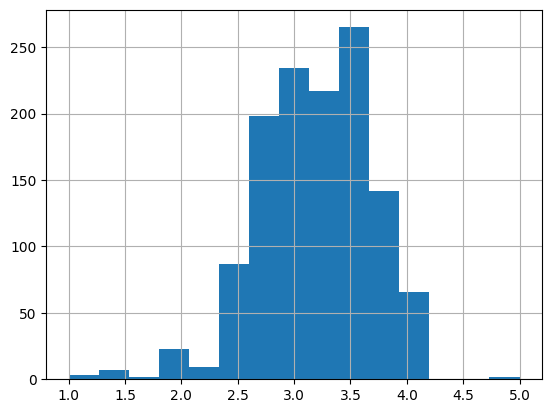

In [ ]:
train_df.Rating.hist(bins=15);

Распределение похоже на нормальное. Мне кажется, можно ничего особого с этим не делать

# Обучаемся

In [ ]:
train_df.shape

(1255, 7)

In [ ]:
train_df.head()

,Company,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,Willie's Cacao,2009,0.72,U.K.,3.25,Trinitario,Venezuela
1,Beschle (Felchlin),2010,0.72,Switzerland,3.50,Other,Venezuela
2,Dark Forest,2015,0.70,U.S.A.,3.00,Other,Tanzania
3,Brasstown aka It's Chocolate,2013,0.72,U.S.A.,3.00,Trinitario,Dominican Republic
4,Pralus,2006,0.75,France,3.50,Criollo,Other


In [ ]:
train_df.shape

(1255, 7)

In [ ]:
!pip install catboost -q

In [ ]:
X_train = train_df.drop('Rating', axis=1)
y_train = train_df['Rating']

In [ ]:
cat_cols = X_train.select_dtypes(include=['object']).columns

In [ ]:
cat_features = [list(X_train.columns).index(c) for c in cat_cols]

In [ ]:
cat_features

[0, 3, 4, 5]

In [ ]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(cat_features=cat_features)

model.fit(X_train, y_train)

Learning rate set to 0.042439
0:	learn: 0.4767030	total: 50.6ms	remaining: 50.5s
1:	learn: 0.4740784	total: 53.9ms	remaining: 26.9s
2:	learn: 0.4717518	total: 57.2ms	remaining: 19s
3:	learn: 0.4696945	total: 59.9ms	remaining: 14.9s
4:	learn: 0.4676471	total: 63.5ms	remaining: 12.6s
5:	learn: 0.4653687	total: 66.2ms	remaining: 11s
6:	learn: 0.4633588	total: 68.4ms	remaining: 9.7s
7:	learn: 0.4613473	total: 70.7ms	remaining: 8.76s
8:	learn: 0.4595928	total: 73ms	remaining: 8.04s
9:	learn: 0.4580761	total: 75.2ms	remaining: 7.44s
10:	learn: 0.4561885	total: 77.2ms	remaining: 6.94s
11:	learn: 0.4549306	total: 78.4ms	remaining: 6.45s
12:	learn: 0.4535947	total: 80.8ms	remaining: 6.13s
13:	learn: 0.4519153	total: 82.7ms	remaining: 5.83s
14:	learn: 0.4504041	total: 84.8ms	remaining: 5.57s
15:	learn: 0.4494044	total: 86.7ms	remaining: 5.33s
16:	learn: 0.4488877	total: 87.2ms	remaining: 5.04s
17:	learn: 0.4473223	total: 89.4ms	remaining: 4.88s
18:	learn: 0.4456767	total: 91.5ms	remaining: 4.72s

In [ ]:
model.score(X_train, y_train)

0.4402822995024327

Загружаем тестовые данные

Сохраняем предсказание в файл в нужном формате

In [ ]:
# test_df['id'] = np.arange(len(test_df))
# test_df['Rating'] = pred

# test_df[['id','Rating']].to_csv("baseline_submission.csv", index=False)

## Подбираем модель

In [ ]:
X = train_df.drop('Rating', axis=1)
y = train_df['Rating']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
!pip install category_encoders -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 KB 3.1 MB/s eta 0:00:00


In [ ]:
from category_encoders.leave_one_out import LeaveOneOutEncoder
from category_encoders.one_hot import OneHotEncoder
from category_encoders.target_encoder import TargetEncoder

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [ ]:
from sklearn.pipeline import Pipeline

In [ ]:
from sklearn.metrics import r2_score

In [ ]:
model1 = LinearRegression()

In [ ]:
cat_cols

Index(['Company', 'Company Location', 'Bean Type', 'Broad Bean Origin'], dtype='object')

## Линейные модели

In [ ]:
p1 = Pipeline([
    ('encoder_', LeaveOneOutEncoder(cols=cat_cols)),
    ('model_', LinearRegression())
    ])

p2 = Pipeline([
    ('encoder_', OneHotEncoder(cols=cat_cols)),
    ('model_', LinearRegression())
    ])

p3 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols, smoothing=100)),
    ('model_', LinearRegression())
    ])

p4 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols, smoothing=1)),
    ('model_', LinearRegression())
    ])

p5 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols, smoothing=10)),
    ('model_', LinearRegression())
    ])

In [ ]:
for i,p in enumerate([p1,p2,p3,p4,p5]):
    p.fit(X_train, y_train)
    pred = p.predict(X_test)
    print(i+1, r2_score(y_test, pred))

1 0.10111624364991334
2 -2.962694842170314e+20
3 0.03334455815069082
4 0.06792554030763709
5 0.06012129610101602


## RidgeRegression

In [ ]:
p01 = Pipeline([
    ('encoder_', LeaveOneOutEncoder(cols=cat_cols)),
    ('model_', Ridge())
    ])

p02 = Pipeline([
    ('encoder_', OneHotEncoder(cols=cat_cols)),
    ('model_', Ridge())
    ])

p03 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols, smoothing=100)),
    ('model_', Ridge())
    ])

p04 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols, smoothing=1)),
    ('model_', Ridge())
    ])

p05 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols, smoothing=10)),
    ('model_', Ridge())
    ])

In [ ]:
for i,p in enumerate([p01,p02,p03,p04,p05]):
    p.fit(X_train, y_train)
    pred = p.predict(X_test)
    print(i+1, r2_score(y_test, pred))

1 0.09622101424414675
2 0.11994520519698493
3 0.04500620767786767
4 0.063083245653209
5 0.09887354558563144


## Решающее дерево

In [ ]:
p9 = Pipeline([
    ('encoder_', OneHotEncoder(cols=cat_cols)),
    ('model_', DecisionTreeRegressor())
    ])

In [ ]:
p9.fit(X_train, y_train)
pred = p9.predict(X_test)
print(r2_score(y_test, pred))

-0.19072744581979517


## Random Forest

In [ ]:
p6 = Pipeline([
    ('encoder_', LeaveOneOutEncoder(cols=cat_cols)),
    ('model_', RandomForestRegressor(n_jobs=-1))
    ])

p7 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols, smoothing=1)),
    ('model_', RandomForestRegressor(n_jobs=-1))
    ])

p8 = Pipeline([
    ('encoder_', OneHotEncoder(cols=cat_cols)),
    ('model_', RandomForestRegressor(n_jobs=-1))
    ])

In [ ]:
for i,p in enumerate([p6,p7,p8]):
    p.fit(X_train, y_train)
    pred = p.predict(X_test)
    print(i+1, r2_score(y_test, pred))

1 0.02738915891730631
2 0.129513519076073
3 0.20470835247653318


In [ ]:
!pip install optuna -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.3/212.3 KB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 9.6 MB/s eta 0:00:00


In [ ]:
data_pipeline = Pipeline([
        ('encoder_',TargetEncoder(cols=cat_cols)),
        ])

X_train_good = data_pipeline.fit_transform(X_train, y_train)
X_test_good = data_pipeline.transform(X_test)

In [ ]:
import optuna

def objective(trial):

    param = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 1000),
        "max_features": trial.suggest_float("max_features", 0.1, 1.)
    }

    estimator = RandomForestRegressor(**param, verbose=False, n_jobs=-1)

    estimator.fit(X_train_good, y_train)
    pred = estimator.predict(X_test_good)

    return r2_score(y_test, pred)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
print(study.best_trial)

[I 2023-04-05 20:32:54,619] A new study created in memory with name: no-name-1a76af68-6f04-4885-85b2-d9eea34f69db
[I 2023-04-05 20:32:55,994] Trial 0 finished with value: 0.1272076075327334 and parameters: {'n_estimators': 315, 'max_features': 0.4865046399306049}. Best is trial 0 with value: 0.1272076075327334.
[I 2023-04-05 20:32:57,210] Trial 1 finished with value: 0.16005017944810052 and parameters: {'n_estimators': 451, 'max_features': 0.3027316287148716}. Best is trial 1 with value: 0.16005017944810052.
[I 2023-04-05 20:33:01,321] Trial 2 finished with value: 0.08559508429437568 and parameters: {'n_estimators': 904, 'max_features': 0.6881847459056177}. Best is trial 1 with value: 0.16005017944810052.
[I 2023-04-05 20:33:02,377] Trial 3 finished with value: 0.09346580015843098 and parameters: {'n_estimators': 358, 'max_features': 0.5951142753726847}. Best is trial 1 with value: 0.16005017944810052.
[I 2023-04-05 20:33:02,761] Trial 4 finished with value: 0.15741062341123346 and par

FrozenTrial(number=21, state=TrialState.COMPLETE, values=[0.16893988003765636], datetime_start=datetime.datetime(2023, 4, 5, 20, 33, 21, 840837), datetime_complete=datetime.datetime(2023, 4, 5, 20, 33, 22, 953035), params={'n_estimators': 459, 'max_features': 0.22422704454158304}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=10, step=1), 'max_features': FloatDistribution(high=1.0, log=False, low=0.1, step=None)}, trial_id=21, value=None)


## CatBoost

In [ ]:
model = CatBoostRegressor(cat_features=cat_features)

model.fit(X_train, y_train)
pred = model.predict(X_test)
print(r2_score(y_test, pred))

Learning rate set to 0.04011
0:	learn: 0.4729551	total: 3.18ms	remaining: 3.17s
1:	learn: 0.4710469	total: 5.97ms	remaining: 2.98s
2:	learn: 0.4687998	total: 9.1ms	remaining: 3.02s
3:	learn: 0.4663944	total: 11.9ms	remaining: 2.96s
4:	learn: 0.4646352	total: 14.4ms	remaining: 2.86s
5:	learn: 0.4627186	total: 17.2ms	remaining: 2.85s
6:	learn: 0.4609487	total: 19.5ms	remaining: 2.77s
7:	learn: 0.4592060	total: 21.6ms	remaining: 2.68s
8:	learn: 0.4571151	total: 24.6ms	remaining: 2.71s
9:	learn: 0.4552013	total: 27.1ms	remaining: 2.68s
10:	learn: 0.4539225	total: 29.8ms	remaining: 2.68s
11:	learn: 0.4522231	total: 32.6ms	remaining: 2.68s
12:	learn: 0.4506395	total: 37.6ms	remaining: 2.86s
13:	learn: 0.4491403	total: 40.4ms	remaining: 2.84s
14:	learn: 0.4482026	total: 41.6ms	remaining: 2.73s
15:	learn: 0.4467794	total: 44.1ms	remaining: 2.71s
16:	learn: 0.4462560	total: 45.1ms	remaining: 2.61s
17:	learn: 0.4443760	total: 47.8ms	remaining: 2.61s
18:	learn: 0.4431132	total: 50.4ms	remaining: 

## Ансамбли и кросс-валидация

In [ ]:
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import r2_score

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
new_data_pipeline = Pipeline([
        ('encoder_',TargetEncoder(cols=cat_cols)),
        ])

X_good = new_data_pipeline.fit_transform(X, y)

In [ ]:
gbm = GradientBoostingRegressor()

cross_val_score(gbm, X_good, y, cv=3, scoring='r2', return_estimator=True).mean()

0.4325753363989026

In [ ]:
!pip install xgboost -q

In [ ]:
from xgboost import XGBRegressor

xgb = XGBRegressor()

cross_val_score(xgb, X_good, y, cv=3, scoring='r2').mean()

0.2766441976646347

In [ ]:
cb = CatBoostRegressor(verbose=0)

cross_val_score(cb, X_good, y, cv=3, scoring='r2').mean()  ## лучшая модель ever

0.4180137691391724

In [ ]:
cb2 = CatBoostRegressor(cat_features=cat_features, verbose=0)

cross_val_score(cb2, X, y, cv=3, scoring='r2').mean()

0.16134233889639585

In [ ]:
!pip install lightgbm -q

In [ ]:
from lightgbm import LGBMRegressor

lgbm = LGBMRegressor()

cross_val_score(lgbm, X_good, y, cv=3, scoring='r2').mean()

0.3726588840794778

In [ ]:
def objective(trial):

    param = {
        "max_depth": trial.suggest_int("max_features", 2, 16)
    }

    estimator = CatBoostRegressor(**param, verbose=False)

    estimator.fit(X_train_good, y_train)
    pred = estimator.predict(X_test_good)

    return r2_score(y_test, pred)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
print(study.best_trial)

[I 2023-04-05 21:15:02,446] A new study created in memory with name: no-name-d0de83c4-38fd-4fed-9438-6321348c6d35
[I 2023-04-05 21:15:08,142] Trial 0 finished with value: 0.06223271077567516 and parameters: {'max_features': 9}. Best is trial 0 with value: 0.06223271077567516.
[I 2023-04-05 21:15:09,400] Trial 1 finished with value: 0.08111593623515234 and parameters: {'max_features': 7}. Best is trial 1 with value: 0.08111593623515234.
[I 2023-04-05 21:15:29,607] Trial 2 finished with value: 0.07294983537874555 and parameters: {'max_features': 13}. Best is trial 1 with value: 0.08111593623515234.
[I 2023-04-05 21:15:30,695] Trial 3 finished with value: 0.10462063903469643 and parameters: {'max_features': 6}. Best is trial 3 with value: 0.10462063903469643.
[I 2023-04-05 21:15:31,481] Trial 4 finished with value: 0.11832194044499389 and parameters: {'max_features': 3}. Best is trial 4 with value: 0.11832194044499389.
[I 2023-04-05 21:15:33,438] Trial 5 finished with value: 0.09289504104

FrozenTrial(number=12, state=TrialState.COMPLETE, values=[0.12076807336999429], datetime_start=datetime.datetime(2023, 4, 5, 21, 23, 14, 80865), datetime_complete=datetime.datetime(2023, 4, 5, 21, 23, 15, 160636), params={'max_features': 4}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_features': IntDistribution(high=16, log=False, low=2, step=1)}, trial_id=12, value=None)


In [ ]:
params = {'max_depth' : [2, 5, 8, 11]}

In [ ]:
gs_cb = GridSearchCV(cb, params, cv=3, scoring='r2', verbose=2)

gs_cb.fit(X_good, y)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END ........................................max_depth=2; total time=   1.6s
[CV] END ........................................max_depth=2; total time=   1.4s
[CV] END ........................................max_depth=2; total time=   1.4s
[CV] END ........................................max_depth=5; total time=   1.0s
[CV] END ........................................max_depth=5; total time=   0.9s
[CV] END ........................................max_depth=5; total time=   0.9s
[CV] END ........................................max_depth=8; total time=   1.6s
[CV] END ........................................max_depth=8; total time=   1.6s
[CV] END ........................................max_depth=8; total time=   1.5s
[CV] END .......................................max_depth=11; total time=   8.9s
[CV] END .......................................max_depth=11; total time=   6.0s
[CV] END .......................................m

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f601d10bb20>,
             param_grid={'max_depth': [2, 5, 8, 11]}, scoring='r2', verbose=2)

In [ ]:
gs_cb.best_params_


{'max_depth': 2}

In [ ]:
gbm_model = gbm.fit(X_good, y)

## Применение моделей

In [ ]:
test_df = pd.read_csv('chocolate_test_new.csv')

In [ ]:
test_df

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Bean Type,Broad Bean Origin
0,Ohiyo,"San Juan Estate, Gran Couva",1594,2015,70%,U.S.A.,Trinitario,Trinidad
1,Blanxart,Organic Dark,322,2009,72%,Spain,,
2,Brazen,Maya Mountain,1518,2015,80%,U.S.A.,Trinitario,Belize
3,Patric,Madagascar,439,2009,67%,U.S.A.,Trinitario,Madagascar
4,Potomac,"Upala, Batch 12",607,2010,82%,U.S.A.,Matina,Costa Rica
...,...,...,...,...,...,...,...,...
535,Monsieur Truffe,Papaua New Guinea,1391,2014,70%,Australia,,Papua New Guinea
536,Cacao Hunters,Macondo,1816,2016,71%,Colombia,,Colombia
537,Bonnat,Maragnam,1038,2013,75%,France,,Brazil
538,Altus aka Cao Artisan,Acopagro,1728,2016,60%,U.S.A.,,Peru


In [ ]:
test_df = test_df.replace(np.nan, 'Other')

In [ ]:
test_df = test_df.replace(r'^\s*$', 'Other', regex=True)

In [ ]:
test_df['Cocoa Percent'] = test_df['Cocoa Percent'].apply(lambda x: float(x.strip('%')) / 100.0)

In [ ]:
test_df['Bean Type'] = test_df['Bean Type'].apply(lambda x: x.split()[0].strip().strip(','))

In [ ]:
test_df['Bean Type'] = test_df['Bean Type'].apply(lambda x: x if x not in rear_beans else 'Other')

In [ ]:
test_df['Broad Bean Origin'] = test_df['Broad Bean Origin'].apply(lambda x: "Dominican Republic" if x == 'Domincan Republic' else x)

In [ ]:
test_df['Broad Bean Origin'] = test_df['Broad Bean Origin'].apply(lambda x: x if x in most_bean_origin else 'Other')

In [ ]:
test_df['Company Location'] = test_df['Company Location'].apply(lambda x: x if x in most_located_countries else 'Other')

In [ ]:
test_df['Specific Bean Origin'] = test_df['Specific Bean Origin'].apply(lambda x: x if x in most_specific_countries else 'Other')

In [ ]:
test_df.drop(columns=['Specific Bean Origin', 'REF'], inplace=True)

In [ ]:
test_df

,Company,Review,Cocoa Percent,Company Location,Bean Type,Broad Bean Origin
0,Ohiyo,2015,0.70,U.S.A.,Trinitario,Trinidad
1,Blanxart,2009,0.72,Spain,Other,Other
2,Brazen,2015,0.80,U.S.A.,Trinitario,Belize
3,Patric,2009,0.67,U.S.A.,Trinitario,Madagascar
4,Potomac,2010,0.82,U.S.A.,Other,Costa Rica
...,...,...,...,...,...,...
535,Monsieur Truffe,2014,0.70,Australia,Other,Papua New Guinea
536,Cacao Hunters,2016,0.71,Colombia,Other,Colombia
537,Bonnat,2013,0.75,France,Other,Brazil
538,Altus aka Cao Artisan,2016,0.60,U.S.A.,Other,Peru


In [ ]:
test_good = new_data_pipeline.transform(test_df)

In [ ]:
test_good

,Company,Review,Cocoa Percent,Company Location,Bean Type,Broad Bean Origin
0,3.176494,2015,0.70,3.142994,3.256803,3.162524
1,3.218585,2009,0.72,3.187181,3.134766,3.111520
2,3.167844,2015,0.80,3.142994,3.256803,3.218047
3,3.303697,2009,0.67,3.142994,3.256803,3.252408
4,3.204652,2010,0.82,3.142994,3.134766,3.112205
...,...,...,...,...,...,...
535,3.176494,2014,0.70,3.305034,3.134766,3.243695
536,3.257846,2016,0.71,3.120282,3.134766,3.149455
537,3.281997,2013,0.75,3.260770,3.134766,3.248586
538,3.106706,2016,0.60,3.142994,3.134766,3.151640


In [ ]:
my_preds = gs_cb.predict(test_good)

In [ ]:
my_preds

array([3.1614341 , 3.29945774, 3.11708744, 3.86412341, 3.18023084,
       2.38652694, 3.12507229, 3.18203175, 3.22243334, 2.55413819,
       3.17632747, 3.23218423, 2.91119879, 3.19023607, 2.69496149,
       3.10581193, 3.47191692, 3.43250236, 3.17064619, 3.03706123,
       3.19794031, 3.64454519, 3.50447046, 2.96780486, 3.56937068,
       3.46101155, 3.61069696, 3.24736188, 3.18474594, 2.83068267,
       3.55013646, 2.07488698, 2.5465197 , 2.88749825, 3.04260878,
       3.54154276, 3.65319236, 2.78466333, 3.5448032 , 3.05580139,
       2.82325721, 3.18494438, 2.9038735 , 3.6314007 , 3.29375183,
       3.66493191, 3.51348045, 3.52672221, 3.19766214, 3.18448959,
       2.58823928, 3.1232788 , 3.52786205, 3.0643665 , 3.64522553,
       2.95346716, 3.01277943, 3.06691867, 3.06155818, 2.82136329,
       3.32492663, 3.37524885, 3.20108931, 3.24051882, 2.9560182 ,
       1.27052423, 2.72344914, 3.10103175, 3.53957526, 3.43410005,
       3.16810801, 3.26931365, 3.20110067, 3.65876267, 3.06423

In [ ]:
my_preds_2 = gbm_model.predict(test_good)

In [ ]:
my_preds_2

array([3.16933176, 3.27014281, 3.09087223, 3.83733355, 3.11987883,
       2.50881481, 3.13883885, 3.21074741, 3.24414348, 2.66056644,
       3.1807891 , 3.23185086, 2.94932623, 3.21074741, 2.91805086,
       3.15133473, 3.43314609, 3.3888125 , 3.19691826, 3.07601687,
       3.22673522, 3.6889395 , 3.42393531, 2.97849827, 3.52544475,
       3.49182502, 3.58623017, 3.21534446, 3.13844447, 2.47765322,
       3.51341958, 2.34420108, 2.4475326 , 2.94634765, 3.02870895,
       3.51502845, 3.55691555, 2.76673064, 3.53455453, 3.05212898,
       2.83041556, 3.18103856, 2.94697373, 3.58118149, 3.32028114,
       3.71738851, 3.50034326, 3.55798364, 3.21708658, 3.25232742,
       2.5368675 , 3.12194059, 3.56288279, 3.03367753, 3.52019409,
       2.89512249, 3.0514767 , 3.00581213, 3.15587689, 2.82077662,
       3.33002219, 3.42821158, 3.213371  , 3.23513368, 2.96960845,
       1.3299995 , 2.67082418, 3.08720197, 3.51946834, 3.43278217,
       3.18852349, 3.26746988, 3.21074741, 3.65177465, 3.03956

In [ ]:
test_good['id'] = np.arange(len(test_good))
test_good['Rating'] = my_preds

test_good[['id','Rating']].to_csv("my_baseline_CB.csv", index=False)

In [ ]:
test_good['Rating'] = my_preds_2

test_good[['id','Rating']].to_csv("my_baseline_GBR.csv", index=False)

In [ ]:
def full_transform_df(test_df):
  test_df = test_df.replace(np.nan, 'Other')
  test_df = test_df.replace(r'^\s*$', 'Other', regex=True)
  test_df['Cocoa Percent'] = test_df['Cocoa Percent'].apply(lambda x: float(x.strip('%')) / 100.0)
  test_df['Bean Type'] = test_df['Bean Type'].apply(lambda x: x.split()[0].strip().strip(','))
  test_df['Bean Type'] = test_df['Bean Type'].apply(lambda x: x if x not in rear_beans else 'Other')
  test_df['Broad Bean Origin'] = test_df['Broad Bean Origin'].apply(lambda x: "Dominican Republic" if x == 'Domincan Republic' else x)
  test_df['Broad Bean Origin'] = test_df['Broad Bean Origin'].apply(lambda x: x if x in most_bean_origin else 'Other')
  test_df.drop(columns=['Specific Bean Origin', 'REF', 'Company Location', 'Review'], inplace=True)
  return test_df

In [ ]:
train_df = pd.read_csv('chocolate_train.csv')

In [ ]:
train_df = full_transform_df(train_df)

In [ ]:
train_df

,Company,Cocoa Percent,Rating,Bean Type,Broad Bean Origin
0,Willie's Cacao,0.72,3.25,Trinitario,Venezuela
1,Beschle (Felchlin),0.72,3.50,Other,Venezuela
2,Dark Forest,0.70,3.00,Other,Tanzania
3,Brasstown aka It's Chocolate,0.72,3.00,Trinitario,Dominican Republic
4,Pralus,0.75,3.50,Criollo,Other
...,...,...,...,...,...
1250,Artisan du Chocolat,0.80,3.00,Criollo,Madagascar
1251,Marana,0.70,2.75,Other,Peru
1252,Arete,0.68,3.50,Forastero,Peru
1253,Fresco,0.72,3.50,Other,Dominican Republic


In [ ]:
X_train = train_df.drop('Rating', axis=1)
y_train = train_df['Rating']

In [ ]:
cat_cols = X_train.select_dtypes(include=['object']).columns

In [ ]:
cat_features = [list(X_train.columns).index(c) for c in cat_cols]

In [ ]:
cat_features

[0, 2, 3]

In [ ]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(cat_features=cat_features)

model.fit(X_train, y_train)

Learning rate set to 0.042439
0:	learn: 0.4763134	total: 2.7ms	remaining: 2.7s
1:	learn: 0.4741111	total: 3.96ms	remaining: 1.97s
2:	learn: 0.4721108	total: 5.39ms	remaining: 1.79s
3:	learn: 0.4703515	total: 7.11ms	remaining: 1.77s
4:	learn: 0.4683223	total: 8.64ms	remaining: 1.72s
5:	learn: 0.4664973	total: 9.53ms	remaining: 1.58s
6:	learn: 0.4646694	total: 11.8ms	remaining: 1.68s
7:	learn: 0.4630896	total: 13.9ms	remaining: 1.72s
8:	learn: 0.4617542	total: 14.7ms	remaining: 1.62s
9:	learn: 0.4598156	total: 16.3ms	remaining: 1.61s
10:	learn: 0.4584670	total: 18.2ms	remaining: 1.63s
11:	learn: 0.4572191	total: 20ms	remaining: 1.65s
12:	learn: 0.4565367	total: 20.7ms	remaining: 1.57s
13:	learn: 0.4555182	total: 22.6ms	remaining: 1.59s
14:	learn: 0.4542740	total: 27.7ms	remaining: 1.81s
15:	learn: 0.4529484	total: 30.3ms	remaining: 1.86s
16:	learn: 0.4514264	total: 32.2ms	remaining: 1.86s
17:	learn: 0.4499197	total: 33.9ms	remaining: 1.85s
18:	learn: 0.4483852	total: 35.8ms	remaining: 1.

In [ ]:
test_df = pd.read_csv('chocolate_test_new.csv')

In [ ]:
test_df = full_transform_df(test_df)

In [ ]:
preds = model.predict(test_df)

In [ ]:
test_df['id'] = np.arange(len(test_df))
test_df['Rating'] = preds

test_df[['id','Rating']].to_csv("my_base_CB.csv", index=False)

In [ ]:
def short_transform_df(test_df):
  test_df = test_df.replace(np.nan, 'Other')
  test_df = test_df.replace(r'^\s*$', 'Other', regex=True)
  test_df['Cocoa Percent'] = test_df['Cocoa Percent'].apply(lambda x: float(x.strip('%')) / 100.0)
  test_df['Bean Type'] = test_df['Bean Type'].apply(lambda x: x.split()[0].strip().strip(','))
  test_df['Broad Bean Origin'] = test_df['Broad Bean Origin'].apply(lambda x: "Dominican Republic" if x == 'Domincan Republic' else x)
  test_df.drop(columns=['Specific Bean Origin', 'REF', 'Company Location', 'Review'], inplace=True)
  return test_df

In [ ]:
def prepare_train():
  train_df = pd.read_csv('chocolate_train.csv')
  train_df = short_transform_df(train_df)
  X_train = train_df.drop('Rating', axis=1)
  y_train = train_df['Rating']
  cat_cols = X_train.select_dtypes(include=['object']).columns
  cat_features = [list(X_train.columns).index(c) for c in cat_cols]
  return X_train, y_train, cat_features

In [ ]:
X_train, y_train, cat_features = prepare_train()

In [ ]:
model = CatBoostRegressor(cat_features=cat_features)
model.fit(X_train, y_train)
test_df = pd.read_csv('chocolate_test_new.csv')
test_df = short_transform_df(test_df)
preds = model.predict(test_df)

Learning rate set to 0.042439
0:	learn: 0.4763307	total: 4.41ms	remaining: 4.41s
1:	learn: 0.4738005	total: 6.67ms	remaining: 3.33s
2:	learn: 0.4717059	total: 8.87ms	remaining: 2.95s
3:	learn: 0.4697424	total: 11.2ms	remaining: 2.79s
4:	learn: 0.4676141	total: 13.4ms	remaining: 2.66s
5:	learn: 0.4654192	total: 15.5ms	remaining: 2.56s
6:	learn: 0.4634622	total: 17.5ms	remaining: 2.48s
7:	learn: 0.4618866	total: 19.4ms	remaining: 2.4s
8:	learn: 0.4601144	total: 21.9ms	remaining: 2.42s
9:	learn: 0.4585694	total: 24.3ms	remaining: 2.4s
10:	learn: 0.4571764	total: 26.5ms	remaining: 2.38s
11:	learn: 0.4560068	total: 28.2ms	remaining: 2.32s
12:	learn: 0.4549052	total: 30.6ms	remaining: 2.32s
13:	learn: 0.4536034	total: 32.5ms	remaining: 2.29s
14:	learn: 0.4518782	total: 35.3ms	remaining: 2.31s
15:	learn: 0.4506203	total: 37.2ms	remaining: 2.29s
16:	learn: 0.4498499	total: 39.2ms	remaining: 2.27s
17:	learn: 0.4487519	total: 41.7ms	remaining: 2.28s
18:	learn: 0.4476183	total: 43.8ms	remaining: 

In [ ]:
test_df['id'] = np.arange(len(test_df))
test_df['Rating'] = preds

test_df[['id','Rating']].to_csv("my_base.csv", index=False)